In [2]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [3]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

### 2PGMI PhysRevA Data

In [25]:
MONO_DATA = np.genfromtxt("mono_contrast_data.csv", delimiter = ",").T
MONO_ERROR = abs(MONO_DATA[1] - (np.genfromtxt("mono_error.csv", delimiter = ",").T)[1])
BI_DATA = np.genfromtxt("bichromatic_from_paper.csv", delimiter = ",").T
BI_ERROR = abs(BI_DATA[1] - (np.genfromtxt("bi_error_paper.csv", delimiter = ",").T)[1])
POLY_DATA = np.genfromtxt("poly_contrast_data.csv", delimiter = ",").T
POLY_ERROR = abs(POLY_DATA[1] - (np.genfromtxt("poly_error_paper.csv", delimiter = ",").T)[1])

In [29]:
len(POLY_DATA[0])

10

### Simulations

In [4]:
p = 2.4e-6
L1mono = 1.2
L1bi = 1.73
L1poly = 4.65

L0mono = -0.05
L0bi = 0.01
L0poly = 0.44
d0 = {"mono": -0.75e-3, "bi": +0.8e-3, "poly": -0.38e-3}


Lmono = 2.99 - L0mono
Lbi = 3.52 - L0bi
Lpoly = 8.8 - L0poly


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lammono = np.array([4.4e-10])
plammono = np.array([1])

lambi = np.array([4.4e-10,2.2e-10, 0])
plambi = np.array([3.2/4.2,1/4.2, 0])

lampoly, plampoly = polyspectrum.copy()


mt = 5
x0 = np.array([0])

Nbc = 5e28*4.149e-15
h = 0.27*pi / (Nbc*4.4e-10)
print(h)
hpoly = 0.2*pi / (Nbc*5e-10)

phimono = Nbc*lammono*h
phibi = Nbc*lambi*h

phipoly = Nbc*lampoly*hpoly


camsize = 2.5e-2
# slitx = 230e-6
slitx_vals = np.arange(100,405,1)*1e-6
# slitxpoly = 590e-6
slitxpoly_vals = np.arange(200,755,1)*1e-6


slity = 100e-6
xbin = 1e-6
ybin = 1e-6
res = 100e-6
respoly = 150e-6


G1sdmono = {"p":p, "L1": np.array([L1mono]), "phi":phimono, "mt": mt, "spectrum_spacing":1}
G1sdmono["L2"] = np.linspace(7,16,19)*1e-3 + d0["mono"]


G2sdmono = {"p":p, "L1": G1sdmono["L1"] +  G1sdmono["L2"], "phi":phimono, "mt": mt, "spectrum_spacing":1}
G2sdmono["L2"] = Lmono - (G1sdmono["L1"] + G1sdmono["L2"])

G1sdbi = {"p":p, "L1": np.array([L1bi]), "phi":phibi, "mt": mt, "spectrum_spacing":1}
G1sdbi["L2"] = np.linspace(7,16,10)*1e-3 + d0["bi"]


G2sdbi = {"p":p, "L1": G1sdbi["L1"] +  G1sdbi["L2"], "phi":phibi, "mt": mt, "spectrum_spacing":1}
G2sdbi["L2"] = Lbi - (G1sdbi["L1"] + G1sdbi["L2"])


G1sdpoly = {"p":p, "L1": np.array([L1poly]), "phi":phipoly, "mt": mt, "spectrum_spacing":1}
G1sdpoly["L2"] = np.linspace(7,16,10)*1e-3 + d0["poly"]


G2sdpoly = {"p":p, "L1": G1sdpoly["L1"] +  G1sdpoly["L2"], "phi":phipoly, "mt": mt, "spectrum_spacing":1}
G2sdpoly["L2"] = Lpoly - (G1sdpoly["L1"] + G1sdpoly["L2"])


# Ioff = np.linspace(-5000,5000,10)
simaptsmono = {"G1":RectGrating(G1sdmono),"G2":RectGrating(G2sdmono)}
siminitmono = {"lam":lammono, "plam": plammono, "L":Lmono,"d":G1sdmono["L2"],"mt":mt, "sum_lam" : False,"xbin":xbin,"ybin":ybin,\
           "p":p ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "resx": res,"resy":res, "batches" : 1000}

simaptsbi = {"G1":RectGrating(G1sdbi),"G2":RectGrating(G2sdbi)}
siminitbi = {"lam":lambi, "plam": plambi, "L":Lbi,"d":G1sdbi["L2"],"mt":mt, "sum_lam" : True,"xbin":xbin,"ybin":ybin,\
           "p":p,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "resx": res,"resy":res, "batches" : 1000}

simaptspoly = {"G1":RectGrating(G1sdpoly),"G2":RectGrating(G2sdpoly)}
siminitpoly = {"lam":lampoly, "plam": plampoly, "sum_lam":True,"L":Lpoly,"d":G1sdpoly["L2"],"mt":mt,"p": p,"xbin":xbin,"ybin":ybin,\
    "camsize" : camsize ,"convmode" : "valid", "slitx": slitxpoly, "slity" : slity, "resx": respoly,"resy":respoly, "batches" : 1000}


9.292819917934708e-06


NameError: name 'slitx' is not defined

In [140]:
t0 = time()

simmono = PGMI(simaptsmono,siminitmono)
simmono.propagate_to("G1")
simmono.propagate_to("G2")
simmono.generate_after("G2")

simbi = PGMI(simaptsbi,siminitbi)
simbi.propagate_to("G1")
simbi.propagate_to("G2")
simbi.generate_after("G2")

simpoly = PGMI(simaptspoly,siminitpoly)
simpoly.propagate_to("G1")
simpoly.propagate_to("G2")
simpoly.generate_after("G2")

print(time() - t0, "seconds")


0.04459118843078613 seconds


/var/folders/3n/7bc2lfys711fxf0lxhyg445h0000gn/T/ipykernel_18238/4273556589.py:390: RuntimeWarning: divide by zero encountered in divide
  self.k0 = 2*np.pi/self.lam


In [141]:
monocont = simmono.get_value("contrast")
bicont = simbi.get_value("contrast")
polycont = simpoly.get_value("contrast")

# monofitparams = simmono.get_value("fitparams")
# bifitparams = simbi.get_value("fitparams")
# polyfitparams = simpoly.get_value("fitparams")

In [129]:
t0 = time()

monocontslit, bicontslit, polycontslit = [],[],[]

for slitx in slitx_vals:
    siminitmono = {"lam":lammono, "plam": plammono, "L":Lmono,"d":G1sdmono["L2"],"mt":mt, "sum_lam" : False,"xbin":xbin,"ybin":ybin,\
               "p":p ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "resx": res,"resy":res, "batches" : 1000}

    siminitbi = {"lam":lambi, "plam": plambi, "L":Lbi,"d":G1sdbi["L2"],"mt":mt, "sum_lam" : True,"xbin":xbin,"ybin":ybin,\
               "p":p,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "resx": res,"resy":res, "batches" : 1000}

    simmono = PGMI(simaptsmono,siminitmono)
    simmono.propagate_to("G1")
    simmono.propagate_to("G2")
    simmono.generate_after("G2")

    simbi = PGMI(simaptsbi,siminitbi)
    simbi.propagate_to("G1")
    simbi.propagate_to("G2")
    simbi.generate_after("G2")
    
    monocontslit.append(simmono.contrast)
    bicontslit.append(simbi.contrast)
    
for slitxpoly in slitxpoly_vals:

    siminitpoly = {"lam":lampoly, "plam": plampoly, "sum_lam":True,"L":Lpoly,"d":G1sdpoly["L2"],"mt":mt,"p": p,"xbin":xbin,"ybin":ybin,\
        "camsize" : camsize ,"convmode" : "valid", "slitx": slitxpoly, "slity" : slity, "resx": respoly,"resy":respoly, "batches" : 1000}
    simpoly = PGMI(simaptspoly,siminitpoly)
    simpoly.propagate_to("G1")
    simpoly.propagate_to("G2")
    simpoly.generate_after("G2")
    polycontslit.append(simpoly.contrast)

print(time() - t0, "seconds")


/var/folders/3n/7bc2lfys711fxf0lxhyg445h0000gn/T/ipykernel_18238/4273556589.py:390: RuntimeWarning: divide by zero encountered in divide
  self.k0 = 2*np.pi/self.lam


15.488947868347168 seconds


In [130]:
monocontslit = np.array(monocontslit)
bicontslit = np.array(bicontslit)
polycontslit = np.array(polycontslit)


monoerror = np.sqrt(np.sum((monocontslit -  MONO_DATA[1:])**2, axis = -1))
bierror = np.sqrt(np.sum((bicontslit -  BI_DATA[1:])**2, axis = -1))
polyerror = np.sqrt(np.sum((polycontslit -  POLY_DATA[1:])**2, axis = -1))

In [148]:
np.argwhere(np.isclose(slitx_vals*1e6, 260))

array([[160]])

In [158]:
print(polyerror[np.argmin(polyerror)])
print(slitxpoly_vals[np.argmin(np.abs(polyerror - 2*0.021385892342086165)) ]*1e6)

0.021385892342086165
683.9999999999999


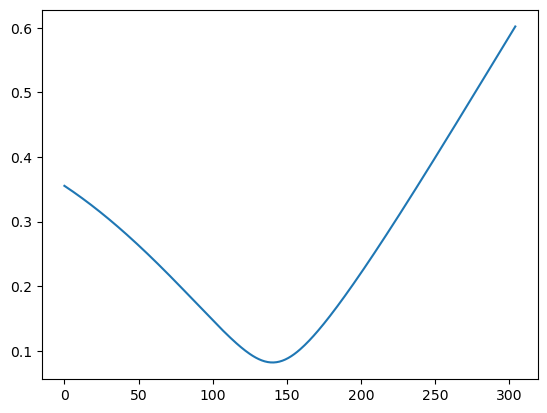

In [136]:

plt.plot(np.sqrt(monoerror**2 + bierror**2))
# plt.plot(polyerror)
plt.show()

In [135]:
slitxerr = np.sqrt(monoerror**2 + bierror**2)
slitx = slitx_vals[np.argmin(slitxerr)]
slitx_uncertainty = slitx * slitxerr[np.argmin(slitxerr)]

slitxpolyerr = polyerror
slitxpoly = slitxpoly_vals[np.argmin(slitxpolyerr)]
slitxpoly_uncertainty = slitxpoly * slitxpolyerr[np.argmin(slitxpolyerr)]
# slitxerr = (polyerror * slitxpoly_vals)[np.argmin(polyerror)]


In [143]:
slitxpoly*1e6

592.0

In [133]:
slitx_uncertainty*1e6

19.693654750943153

In [134]:
slitxpoly_uncertainty*1e6

12.660448266515008

### Plots

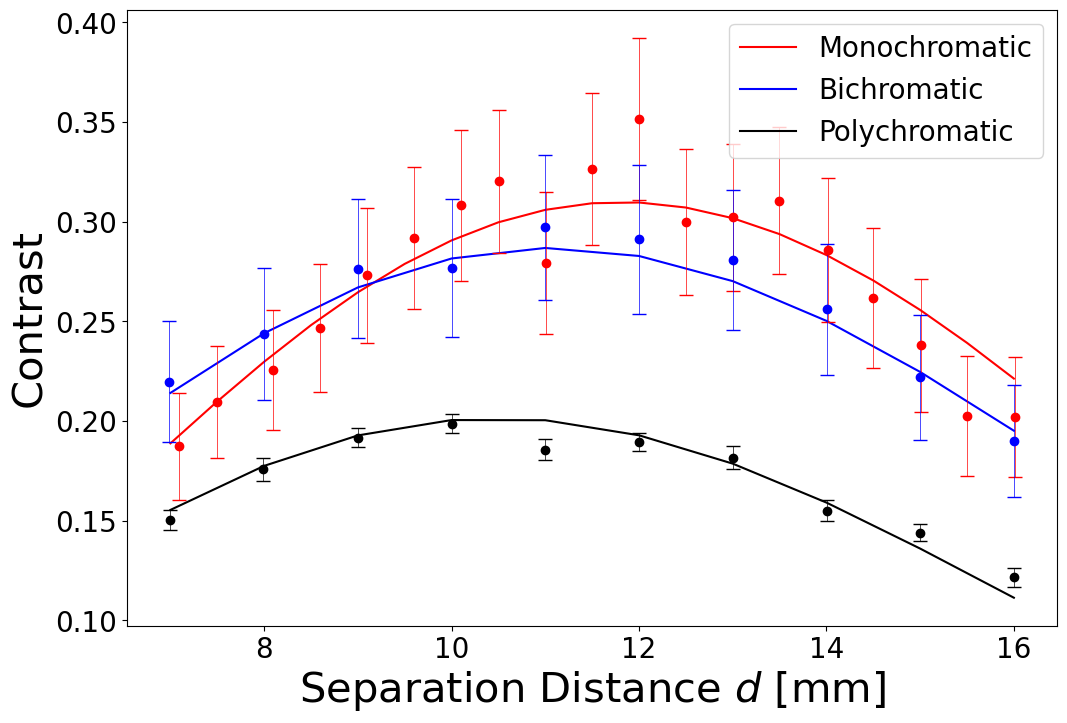

In [142]:
fig, ax1 = plt.subplots(figsize  = (12,8))

colours = ["red","blue", "black"]

ax1.plot((simmono.d - d0["mono"])*1e3, monocont, color = colours[0], label = r"Monochromatic")
ax1.plot((simbi.d - d0["bi"])*1e3, bicont, color = colours[1], label = r"Bichromatic")

ax1.plot((simpoly.d-d0["poly"] )*1e3, polycont, color = colours[2], label = r"Polychromatic")

plt.gca().set_prop_cycle(None)

ax1.errorbar(MONO_DATA[0],MONO_DATA[1],MONO_ERROR, fmt = "ro", elinewidth = 0.5,capsize = 5)
ax1.errorbar(BI_DATA[0]*1e3,BI_DATA[1],BI_ERROR, fmt = "bo", elinewidth = 0.5,capsize = 5)
ax1.errorbar(POLY_DATA[0]*1e3,POLY_DATA[1],POLY_ERROR, fmt = "ko", elinewidth = 0.5,capsize = 5)

# ax1.axvline((p**2/lammono )* 1e3, label = "Predicted max")

ax1.legend(fontsize = 20, loc = "upper right")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax1.set_xlabel("Separation Distance $d$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)

# ax1.set_title("Contrast vs. G1-G2 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
fig.savefig("ContrastVsDfinal.png")
# ax1.set_xlim(0.55,9)
# plt.grid()
plt.show()
plt.close(fig)

In [3]:

p = 180e-6
L = 1.556

lam = np.array([1550e-9])
plam = np.array([1])



x0 = np.array([0])



mt = 5


Nbc = 5e28*4.149e-15

phi = np.array([pi/2])


camsize = 2.5e-2
# slitx = 500e-6
# slity = 100e-6

xbin = 1e-6
ybin = 5e-6

res = 3.75e-6


d12 = np.linspace(37,39,101)*1e-2

d23 = 38e-2
d3c = 38e-2
ds2 = L - d23 - d3c
ds1 = ds2 - d12
d2c = L - ds1 - d12



G1sd = {"p":p, "L1": np.array([ds1]), "phi":phi}
G1sd["L2"] = d12

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi}

G2sd["L2"] = d2c



simaptsIR = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}

siminit = {"lam":lam, "plam":plam, "L":L,"d":d12,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "res": res, "batches" : 5000  }

In [4]:
t0 = time()

simIR = PGMI(simaptsIR, siminit)
simIR.propagate_to("G1")
simIR.propagate_to("G2")
simIR.generate_after("G2")
print(time() - t0, "seconds")


(5000, 101, 5) after parallel
(101, 25000) after reshape
(101, 25000) before convolution
Finding contrast
89.98731279373169 seconds


In [61]:
d12

array([0.37  , 0.3702, 0.3704, 0.3706, 0.3708, 0.371 , 0.3712, 0.3714,
       0.3716, 0.3718, 0.372 , 0.3722, 0.3724, 0.3726, 0.3728, 0.373 ,
       0.3732, 0.3734, 0.3736, 0.3738, 0.374 , 0.3742, 0.3744, 0.3746,
       0.3748, 0.375 , 0.3752, 0.3754, 0.3756, 0.3758, 0.376 , 0.3762,
       0.3764, 0.3766, 0.3768, 0.377 , 0.3772, 0.3774, 0.3776, 0.3778,
       0.378 , 0.3782, 0.3784, 0.3786, 0.3788, 0.379 , 0.3792, 0.3794,
       0.3796, 0.3798, 0.38  , 0.3802, 0.3804, 0.3806, 0.3808, 0.381 ,
       0.3812, 0.3814, 0.3816, 0.3818, 0.382 , 0.3822, 0.3824, 0.3826,
       0.3828, 0.383 , 0.3832, 0.3834, 0.3836, 0.3838, 0.384 , 0.3842,
       0.3844, 0.3846, 0.3848, 0.385 , 0.3852, 0.3854, 0.3856, 0.3858,
       0.386 , 0.3862, 0.3864, 0.3866, 0.3868, 0.387 , 0.3872, 0.3874,
       0.3876, 0.3878, 0.388 , 0.3882, 0.3884, 0.3886, 0.3888, 0.389 ,
       0.3892, 0.3894, 0.3896, 0.3898, 0.39  ])

In [8]:
L*p/simIR.d*1e3

array([0.75697297, 0.75656402, 0.75615551, 0.75574744, 0.75533981,
       0.75493261, 0.75452586, 0.75411955, 0.75371367, 0.75330823,
       0.75290323, 0.75249866, 0.75209452, 0.75169082, 0.75128755,
       0.75088472, 0.75048232, 0.75008034, 0.7496788 , 0.74927769,
       0.74887701, 0.74847675, 0.74807692, 0.74767752, 0.74727855,
       0.74688   , 0.74648188, 0.74608418, 0.7456869 , 0.74529005,
       0.74489362, 0.74449761, 0.74410202, 0.74370685, 0.7433121 ,
       0.74291777, 0.74252386, 0.74213037, 0.74173729, 0.74134463,
       0.74095238, 0.74056055, 0.74016913, 0.73977813, 0.73938754,
       0.73899736, 0.73860759, 0.73821824, 0.73782929, 0.73744076,
       0.73705263, 0.73666491, 0.7362776 , 0.7358907 , 0.7355042 ,
       0.73511811, 0.73473242, 0.73434714, 0.73396226, 0.73357779,
       0.73319372, 0.73281005, 0.73242678, 0.73204391, 0.73166144,
       0.73127937, 0.7308977 , 0.73051643, 0.73013556, 0.72975508,
       0.729375  , 0.72899531, 0.72861602, 0.72823713, 0.72785